<a href="https://colab.research.google.com/github/GergelyTuri/sleep/blob/master/notebooks/attractor/DCA_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototype notebook for toying with attractor models

based on Zhenrui's notebook.

* 3/13/2024 setup

In [ ]:
!git clone https://github.com/GergelyTuri/sleep.git

In [ ]:
%cd sleep
!pip install .

In [ ]:
# %cd sleep
# !git pull

In [ ]:
!pip install git+https://github.com/BouchardLab/DynamicalComponentsAnalysis.git

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [1]:
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
sns.set(context="talk", style="ticks")
import sklearn
import os
from os.path import join
import scipy

from sleep.src import google_drive

# DCA
from dca import DynamicalComponentsAnalysis as DCA, style
from dca.cov_util import calc_cross_cov_mats_from_data
from dca.synth_data import embedded_lorenz_cross_cov_mats, gen_lorenz_data, random_basis, median_subspace
from dca.plotting.fig1 import lorenz_fig_axes, plot_3d, plot_lorenz_3d, plot_traces, plot_dca_demo, plot_r2, plot_cov

In [2]:
useful_data = google_drive.useful_datasets()
useful_data

,mouseID,day,sessionID,cellType,trialID,behavior_file,significantCells,imaging_planes,sima folder,spectral plot,note
0,5HT2afl05b_1,7_7_SD,TSeries-07072021-0833_GC1-001,GC,747,,redo,1,TSeries-07072021-0833_GC1-001_Cycle00001_Eleme...,done,S/N is not so great
1,5HT2afl05b_1,7_7_SD,TSeries-07072021-0833_GC2-003,GC,745,5ht2afl05b_1_20210707120714_745_sleep.json,redo,1,TSeries-07072021-0833_GC2-003_Cycle00001_Eleme...,done,"looks good, uploaded"
2,5HT2afl05b_1,7_7_SD,TSeries-07072021-0833_MC1-002,MC,740,5ht2afl05b_1_20210707110302_740_sleep.json,redo,1,TSeries-07072021-0833_MC1-002_Cycle00001_Eleme...,done,
3,5HT2afl05b_1,7_7_SD,TSeries-07072021-0833_MC2-004,MC,749,5ht2afl05b_1_20210707131056_749_sleep.json,redo,1,TSeries-07072021-0833_MC2-004_Cycle00001_Eleme...,done,nice
4,5HT2afl05b_1,7_12_SD2,TSeries-07122021-0901-002,GC_MC,,,,2,,,
5,5HT2afl05b_2,7_6_SD,TSeries-07062021-0844_GC-001,GC,762,5ht2afl05b_2_20210706101536_762_sleep.json,redo,1,TSeries-07062021-0844_GC-001_Cycle00001_Elemen...,done,S/N is not so great
6,5HT2afl05b_2,7_6_SD,TSeries-07062021-0844_MC-002,MC,761,5ht2afl05b_2_20210706112012_761_sleep.json,redo,1,TSeries-07062021-0844_MC-002_Cycle00001_Elemen...,done,looks good
7,5HT2afl05b_2,7_6_SD,TSeries-07062021-0844_MC2-004,MC,760,5ht2afl05b_2_20210706133302_760_sleep.json,redo,1,TSeries-07062021-0844_MC2-004_Cycle00001_Eleme...,done,"best, uploaded"
8,126031_5,11_23,TSeries-11232022-GC-GC-001,GC,874,126031_5_20221123154956_874_sleep.json,,2,TSeries-11232022-GC-GC-001.sima,,looks very good.
9,126031_5,11_23,TSeries-11232022-GC-MC-002,GC,876,126031_5_20221123163346_876_sleep.json,redo,2,TSeries-11232022-GC-MC-002.sima,,"very nice 2p, but ca signal craps off after ab..."


In [3]:
exp_path = google_drive.return_exp_path('5HT2afl05b_1', '7_12_SD2', 'TSeries-07122021-0901-002')
exp_path

'/gdrive/Shareddrives/Turi_lab/Data/Sleep/2p/Analysis/data/5HT2afl05b_1/7_12_SD2/TSeries-07122021-0901-002'

In [32]:
dfof = pd.read_csv(join(exp_path, "dfof_mc.csv")) # dfof_gc.csv
dfof = dfof.set_index("roi_label")

In [33]:
velo_eeg = pd.read_csv(join(exp_path, 'eeg', "velo_eeg.csv"))

In [34]:
dfof.head(3)

,0,1,2,3,4,5,6,7,8,9,...,37221,37222,37223,37224,37225,37226,37227,37228,37229,37230
roi_label,,,,,,,,,,,,,,,,,,,,,
0001-0301-0458,0.223578,0.287884,0.248868,0.253810,0.132109,0.152893,0.162731,0.204273,0.208865,0.146481,...,0.289756,0.196166,0.128603,0.178520,0.291633,0.205013,0.103306,0.091344,0.289431,0.258004
0001-0258-0459,0.129761,0.201098,0.078216,0.218820,0.091637,0.139136,0.171408,-0.023748,0.092491,0.287586,...,0.220922,0.283505,0.216622,0.214337,0.140702,0.254065,0.245281,0.185409,0.158048,0.255109
0001-0187-0284,0.715851,0.773431,0.699030,0.526918,0.555110,0.720193,0.594098,0.470302,0.470282,0.401885,...,0.040904,0.154393,-0.022856,0.011824,0.006310,0.098696,-0.029104,-0.079864,0.011909,0.039873


In [35]:
dfof.T.iloc[:10000]

roi_label,0001-0301-0458,0001-0258-0459,0001-0187-0284,0001-0186-0362,0001-0162-0170,0001-0193-0316,0001-0303-0434,0001-0345-0304,0001-0280-0177,0001-0195-0401,...,0001-0303-0275,0001-0255-0404,0001-0454-0457,0001-0251-0378,0001-0240-0316,0001-0128-0295,0001-0158-0088,0001-0335-0233,0001-0090-0104,0001-0180-0047
0,0.223578,0.129761,0.715851,0.067111,0.185258,0.083021,0.549367,0.311875,0.600460,0.326130,...,0.210840,0.199083,0.319054,0.563137,0.542651,0.242128,0.099571,0.008737,0.306226,0.181835
1,0.287884,0.201098,0.773431,0.112303,0.194311,0.173516,0.733114,0.586267,0.575808,0.450327,...,0.211593,0.024955,0.622408,0.450045,0.426194,-0.051449,0.102996,0.000365,0.462463,0.390402
2,0.248868,0.078216,0.699030,0.146420,0.165397,0.167279,0.591831,0.381637,0.470842,0.326694,...,0.289003,0.106398,0.371562,0.277913,0.362464,0.167858,0.218701,0.217156,0.189832,0.083989
3,0.253810,0.218820,0.526918,0.084935,0.265106,0.265404,0.468331,0.318541,0.687202,0.103009,...,0.274877,0.048259,0.350746,0.567448,0.342149,0.111717,-0.046223,0.067607,0.260967,0.431694
4,0.132109,0.091637,0.555110,0.075532,0.204459,0.246734,0.545461,0.681908,0.803102,0.316945,...,0.343416,0.064049,0.153411,0.450517,0.224689,0.215245,0.181773,0.345919,0.335978,0.125105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.089760,0.102952,0.139225,-0.041637,0.501004,0.046623,0.148115,0.098047,0.939234,0.117357,...,0.053489,0.100134,0.144226,0.049987,-0.069849,0.184938,0.281177,0.099347,0.030307,-0.003299
9996,0.054256,0.243627,0.034126,0.094126,0.486433,-0.049238,0.151274,0.364492,0.906977,0.253637,...,0.048975,0.044776,0.145238,0.012823,-0.111254,-0.139135,0.267525,0.087924,0.035705,0.119003
9997,0.103876,0.137315,0.214130,-0.002582,0.397367,-0.008193,0.208096,0.321276,1.233606,0.273349,...,0.092639,0.067667,0.121013,0.316382,0.236318,0.116041,0.150354,0.118207,0.150432,0.062717
9998,-0.082864,0.105209,0.110112,0.156241,0.397071,0.128808,-0.065345,0.351579,1.124714,0.061507,...,0.051207,0.065584,0.252000,0.128201,-0.046834,-0.040476,0.142468,0.132999,0.260575,0.033161


In [36]:
#Run DCA
opt = DCA(T=10, d=2)
opt.fit(np.asarray(dfof.T))
V_dca = opt.coef_

#Project data onto DCA and PCA bases
X_dca = np.dot(np.asarray(dfof.T), V_dca)


In [37]:
X_roll = dfof.T.rolling(10).mean().dropna()

In [38]:
opt_roll = DCA(T=10, d=2)
opt_roll.fit(np.asarray(X_roll))
V_dca = opt_roll.coef_

In [39]:
Xroll_dca = np.dot(np.asarray(X_roll), V_dca)


In [40]:
opt_3 = DCA(T=10, d=3)
opt_3.fit(np.asarray(X_roll))
V_dca3 = opt_3.coef_
X_dca3 = np.dot(np.asarray(X_roll), V_dca3)


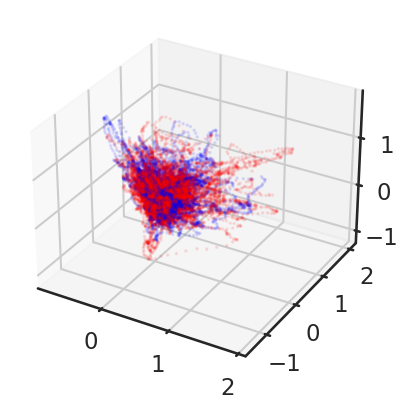

In [41]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_dca3[:, 0], X_dca3[:, 1], X_dca3[:, 2], c=velo_eeg['awake'].iloc[9:], cmap='bwr', s=1,alpha=0.1)
fig.savefig(join(exp_path, 'MC_dca_3d.png'), dpi=300)

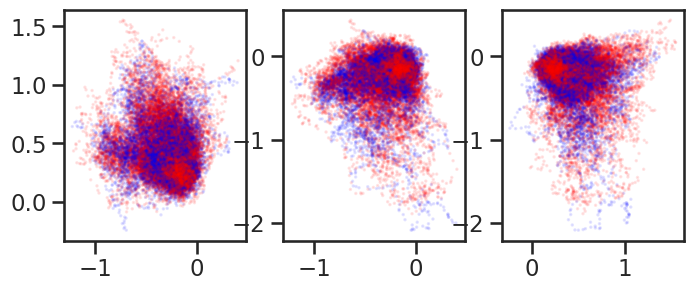

In [28]:
#plt.plot(X_dca[:,0], X_dca[:,1],lw=0.1, c='k')
fig, axes = plt.subplots(1,3,figsize=(8,3))
axes[0].scatter(X_dca3[:,0], X_dca3[:,1],c=velo_eeg['awake'][9:], cmap='bwr',alpha=0.1,s=1)
axes[1].scatter(X_dca3[:,0], X_dca3[:,2],c=velo_eeg['awake'][9:], cmap='bwr',alpha=0.1,s=1)
axes[2].scatter(X_dca3[:,1], X_dca3[:,2],c=velo_eeg['awake'][9:], cmap='bwr',alpha=0.1,s=1)
fig.savefig(join(exp_path, 'GC_dcas.png'), dpi=300)

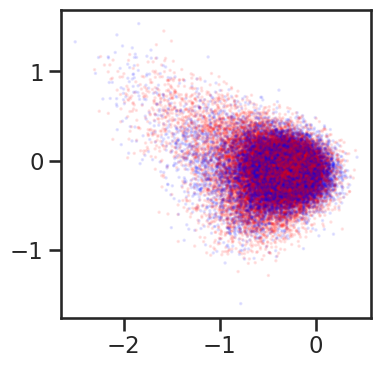

In [29]:
#plt.plot(X_dca[:,0], X_dca[:,1],lw=0.1, c='k')
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X_dca[:,0], X_dca[:,1],c=velo_eeg['awake'], cmap='bwr',alpha=0.1,s=1)
fig.savefig(join(exp_path, 'GC_dca_scatter.png'), dpi=300)

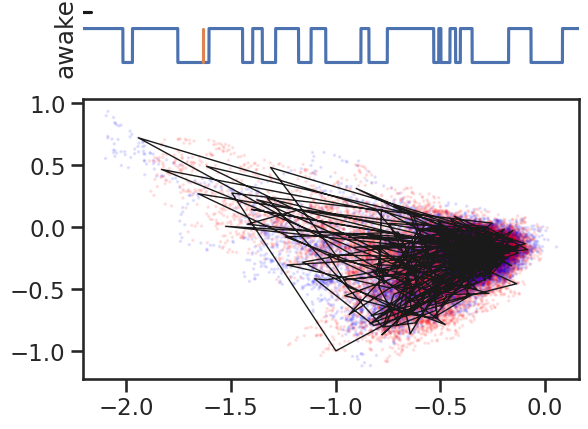

In [30]:
#plt.plot(X_dca[:,0], X_dca[:,1],lw=0.1, c='k')
fig, (ax_state, ax_scatter) = plt.subplots(2,1,gridspec_kw={"height_ratios":[1,5]})
#axes[0].plot(X_dca[:,0], X_dca[:,1],lw=0.1)
ax_state.plot(velo_eeg['awake'].iloc[9:])
sns.despine(ax=ax_state, left=True, bottom=True)
ax_state.set_xlim([9,len(Xroll_dca)])
ax_state.plot([9,9+600],[1.5,1.5],color='k')
ax_state.set_xticks([])
ax_state.set_yticks([])
ax_state.set_ylabel("awake")

line, = ax_state.plot([900, 900], [0,1])
line.set_data([9000, 9000], [0,1])

ax_scatter.scatter(Xroll_dca[:,0], Xroll_dca[:,1],c=velo_eeg['awake'].iloc[9:], cmap='bwr',alpha=0.1,s=1)
ax_scatter.plot(Xroll_dca[::100,0], Xroll_dca[::100,1],lw=1, c='k')

fig.savefig(join(exp_path, 'GC_composit.png'), dpi=300)

In [31]:
from matplotlib.animation import FuncAnimation,FFMpegWriter

fig, (ax_state, ax_scatter) = plt.subplots(2,1,gridspec_kw={"height_ratios":[1,5]})
xdata, ydata = [], []
ln_state, = ax_state.plot([9, 9], [0,1])
ln_scatter, = ax_scatter.plot([], [], 'k-')

line = [ln_state, ln_scatter]

def init():
    ax_state.plot(velo_eeg['awake'].iloc[9:], alpha=0.5)
    sns.despine(ax=ax_state, left=True, bottom=True)
    ax_state.set_xlim([9,len(Xroll_dca)])
    ax_state.plot([9,9+600],[1.5,1.5],color='k')
    ax_state.set_xticks([])
    ax_state.set_yticks([])
    ax_state.set_ylabel("awake")

    ax_scatter.scatter(Xroll_dca[:,0], Xroll_dca[:,1],c=velo_eeg['awake'].iloc[9:], cmap='bwr',alpha=0.1,s=1)
    # ax_scatter.plot(Xroll_dca[::100,0], Xroll_dca[::100,1],lw=1, c='k')

    # ax.scatter(Xroll_dca[:,0], Xroll_dca[:,1],c=velo_eeg['awake'].iloc[9:], cmap='bwr',alpha=0.1,s=1)
    return line

def update(frame):
    x,y = Xroll_dca[frame] #frame
    xdata.append(x)
    ydata.append(y)
    line[1].set_data(xdata[-8:], ydata[-8:])
    line[0].set_data([frame, frame], [0,1])
    return line

ani = FuncAnimation(fig, update, frames=np.arange(0,len(Xroll_dca[9:]),100),#Xroll_dca[::10000],
                    init_func=init, blit=True)
writervideo = FFMpegWriter(fps=6)
ani.save(join(exp_path,'GC_dynamics.mp4'), writer=writervideo)
plt.close()
